<a href="https://colab.research.google.com/github/Simbalas/Segmentation_Predictor/blob/main/Kvasir_SEG_Segmentation_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install imantics
from google.colab import drive
drive.mount('/content/drive')


  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16010 sha256=a3b29688d29453904e0a70c32bb883b0056e70c4b2619226e2828f003ffef35e
  Stored in directory: /root/.cache/pip/wheels/56/6a/be/4c60e88b14abec4e93234a1f7f91ce8abe1ae88a2b3eaad3ac
Successfully built imantics
Mounted at /content/drive


In [2]:
import os

def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file, 'r') as f:
            pass
    except IOError:
        try:
            from google.colab import files
        except ImportError:
            raise IOError("Could not import files from google.colab")

        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key from Kaggle! see: "
                            "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()


Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets list --search 'kvasir-seg'


ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
abdallahwagih/kvasir-dataset-for-classification-and-segmentation  Kvasir Dataset for Classification and Segmentation    1GB  2022-12-11 15:13:24            809         58  0.8125           
debeshjha1/kvasirseg                                              Kvasir-SEG Data (Polyp segmentation & detection)    144MB  2024-02-22 23:37:03            759         23  0.8125           
tanmaydebnath/kvasir-seg-dataset                                  kvasir SEG dataset                                    2GB  2021-06-03 07:41:28            197          4  0.5              
ipythonx/kvasirseg                                

In [4]:
!kaggle datasets download --d 'abdallahwagih/kvasir-dataset-for-classification-and-segmentation'

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation
License(s): CC0-1.0
 99% 1.18G/1.20G [00:15<00:00, 71.3MB/s]
100% 1.20G/1.20G [00:15<00:00, 82.8MB/s]


In [5]:
!unzip kvasir-dataset-for-classification-and-segmentation.zip

Srautinio perdavimo išvestis sutrumpinta iki kelių paskutinių eilučių (5000).
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/00687a70-bbad-4bf9-864f-9f7b3c27a2c8.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0134d93d-0922-4063-9acd-a4177f2b0c07.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01a57b1a-780f-4e52-9f94-291c2982154d.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01f092a2-fccb-49f6-af06-8351c8bb47f1.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/022b40a7-a36f-4510-95a1-b6bb709e94ed.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02b1d319-dea6-418b-969a-c588585cb4f2.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02de4b4c-8704-45f7-b90f-6004d76bdded.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0339a2f7-65bb-41fb-8650-e119670b4e2e.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/03ccdf30-eac8-4e3b-b8e5-54fbf64709dd.jpg  
  inflating: kvasir-dataset/kvasir-datas

In [6]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

images_dir = 'kvasir-seg/Kvasir-SEG/images'
masks_dir = 'kvasir-seg/Kvasir-SEG/masks'
image_size = 512

def read_image(path, image_size=image_size):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    return img

def read_mask(path, image_size=image_size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (image_size, image_size))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.jpg')])

images_train, images_test, masks_train, masks_test = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)


In [7]:
def data_generator(image_files, mask_files, batch_size=8):
    while True:
        for start in range(0, len(image_files), batch_size):
            end = min(start + batch_size, len(image_files))
            batch_images = []
            batch_masks = []
            for i in range(start, end):
                img = read_image(image_files[i])
                mask = read_mask(mask_files[i])
                batch_images.append(img)
                batch_masks.append(mask)
            yield np.array(batch_images), np.array(batch_masks)

batch_size = 8
train_gen = data_generator(images_train, masks_train, batch_size)
val_gen = data_generator(images_test, masks_test, batch_size)


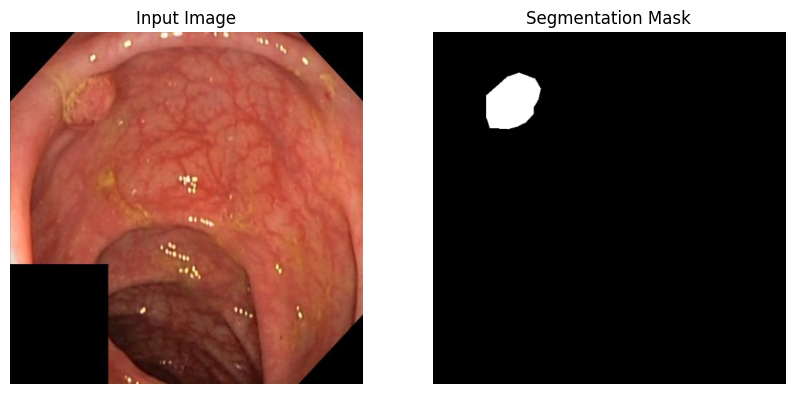

In [8]:
batch_images, batch_masks = next(train_gen)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(batch_images[0])
ax[0].set_title('Input Image')
ax[0].axis('off')
ax[1].imshow(batch_masks[0].squeeze(), cmap='gray')
ax[1].set_title('Segmentation Mask')
ax[1].axis('off')
plt.show()


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_unet_model(img_size):
    inputs = keras.Input(shape=(img_size, img_size, 3))

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_unet_model(image_size)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

steps_per_epoch = len(images_train) // batch_size
validation_steps = len(images_test) // batch_size

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
tensorboard = TensorBoard(log_dir='./logs')

history = model.fit(train_gen, epochs=50, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps, callbacks=[checkpoint, tensorboard])


Epoch 1/50
100/100 [==============================] - 40s 402ms/step - loss: 0.2541 - accuracy: 0.8871 - val_loss: 0.2927 - val_accuracy: 0.8706
Epoch 2/50
100/100 [==============================] - 38s 385ms/step - loss: 0.2344 - accuracy: 0.8959 - val_loss: 0.3298 - val_accuracy: 0.8634
Epoch 3/50
100/100 [==============================] - 40s 401ms/step - loss: 0.2190 - accuracy: 0.9031 - val_loss: 0.2903 - val_accuracy: 0.8759
Epoch 4/50
100/100 [==============================] - 40s 402ms/step - loss: 0.2056 - accuracy: 0.9101 - val_loss: 0.2945 - val_accuracy: 0.8846
Epoch 5/50
100/100 [==============================] - 38s 381ms/step - loss: 0.1941 - accuracy: 0.9152 - val_loss: 0.3505 - val_accuracy: 0.8727
Epoch 6/50
100/100 [==============================] - 40s 400ms/step - loss: 0.1754 - accuracy: 0.9235 - val_loss: 0.6039 - val_accuracy: 0.8433
Epoch 7/50
100/100 [==============================] - 40s 398ms/step - loss: 0.1726 - accuracy: 0.9238 - val_loss: 0.3734 - val_ac

In [78]:
model.load_weights('best_model.h5')

def get_test_data(test_images, test_masks, idx):
    test_image = read_image(test_images[idx])
    test_mask = read_mask(test_masks[idx])
    return test_image, test_mask

test_image, test_mask = get_test_data(images_test, masks_test, 3)
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]


1/1 [==============================] - 0s 22ms/step


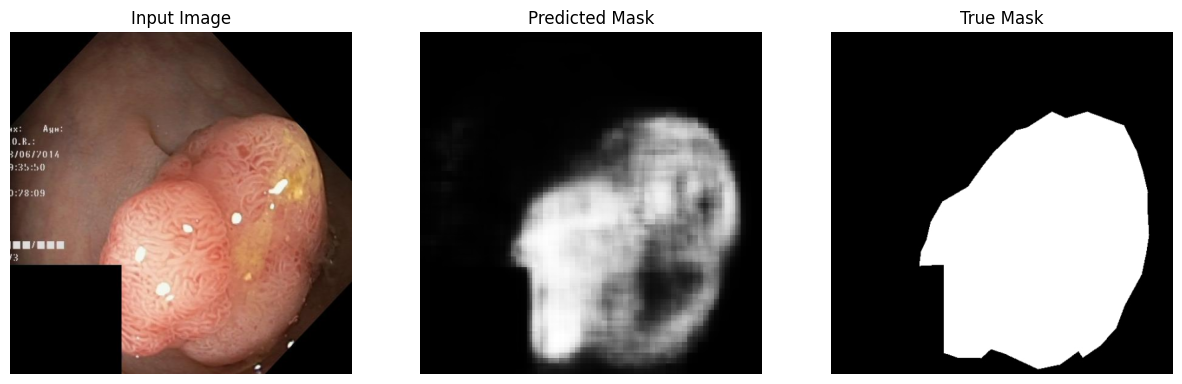

In [79]:
def show_result(test_image, prediction, test_mask):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(test_image)
    axs[0].set_title('Input Image')
    axs[0].axis('off')

    axs[1].imshow(prediction.squeeze(), cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')

    axs[2].imshow(test_mask.squeeze(), cmap='gray')
    axs[2].set_title('True Mask')
    axs[2].axis('off')

    plt.show()

show_result(test_image, prediction, test_mask)
